In [2]:
from torchvision.models.alexnet import alexnet
from torchvision.models.vgg import vgg16
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

#加载数据
# 获得数据
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=227),
    torchvision.transforms.ToTensor()]
)
train_data = torchvision.datasets.FashionMNIST(
    root='./Fashion-mnist',
    train=True,
    transform=transform,
    # transform.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root='./Fashion-mnist',
    train=False,
    transform=transform,
    download=True,
)
# 加载数据
train_loader = DataLoader(dataset=train_data, num_workers=0, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_data, num_workers=0, batch_size=8, shuffle=True)

tensor([2, 3, 0, 5, 9, 1, 7, 7])


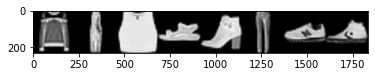

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
tensor([9, 2, 1,  ..., 8, 1, 5])
3


In [3]:
# 展现批次图像
images, labels = next(iter(train_loader))
img = torchvision.utils.make_grid(images)
img = img.numpy().transpose(1, 2, 0)
print(labels)
plt.imshow(img)
plt.show()

print(train_data.data.size())
print(test_data.data.size())
print(test_data.targets)
print(train_data.data.dim())

In [4]:
def get_cuda(x):
    return x.cuda() if torch.cuda.is_available() else x

#复现VGG网络
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],  #常用
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def make_features(cfg: list):
    layers = []
    in_channels = 1
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=(3, 3), padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGG(nn.Module):
    def __init__(self, features, init_weights=False):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(2048, 10),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.features(x)
        # N x 512 x 7 x 7
        x = torch.flatten(x, start_dim=1)
        # N x 512*7*7
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                # nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    return model


vgg = vgg()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 模型训练和优化
# vgg.train()
vgg = vgg.to(device)
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.001)
criteria = torch.nn.CrossEntropyLoss()  # 在使用损失函数的时候应该先实例化然后再调用
epoch = 5

for epoch in range(epoch):
    running_loss = 0.0
    running_correct = 0
    print("{}/{}".format(epoch, epoch))
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        outputs = vgg(data)
        # print(outputs.shape) [32,10]
        pred = torch.max(outputs, 1)[1]
        optimizer.zero_grad()
        loss = criteria(outputs, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_correct += torch.sum(pred == target)
    testing_correct = 0
    for batch_idx, (data_test, target_test) in enumerate(test_loader):
        data_test = get_cuda(data_test)
        target_test = get_cuda(target_test)
        outputs = vgg(data_test)
        pred = torch.max(outputs, 1)[1]
        testing_correct += torch.sum(pred == target_test)
    print("Loss is :{:.4f},Train Accuracy is:{:.4f}%,Test Accuracy is:{:.4f}%".format(
        running_loss / len(train_data), 100 * running_correct / len(train_data),
        100 * testing_correct / len(test_data)))
torch.save(vgg.state_dict(), './weights/VGG/fashion_mnist.pth')  #使用这种方式保存模型，使用其他模型保存方式会出现模型预测出现问题



0/0
Loss is :0.2879,Train Accuracy is:9.9517%,Test Accuracy is:10.0000%
1/1


KeyboardInterrupt: 